# Complexity Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

import os
from os import listdir

from scipy import signal
import scipy.io as sio

from training_helpers import *

In [2]:
## Set random seeds!
torch.manual_seed(0)
np.random.seed(0)

In [3]:
class preamble_detector_fcn(nn.Module):
    def __init__(self):
        super(preamble_detector_fcn, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, (2,35), 1, padding=(0,17), bias=False)
        self.conv2 = nn.Conv2d(16, 32, (1,35), 1, padding=(0,17), bias=False)
        self.conv3 = nn.Conv2d(32, 1, (1,1), 1, padding=(0,0), bias=False)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        
        x = self.conv3(x)
        
        x = x.squeeze()

        return x

In [4]:
model = preamble_detector_fcn()
sum([p.numel() for p in model.parameters()])

19072

In [5]:
class preamble_detector(nn.Module):
    def __init__(self, len_input):
        super(preamble_detector, self).__init__()

        self.fc1 = nn.Linear(len_input*2,40)
        self.fc2 = nn.Linear(40,16)
        self.fc3 = nn.Linear(16,len_input)

    def forward(self, x):
        x = torch.flatten(x,1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        x = self.fc3(x)
        
        x = x.squeeze()

        return x

In [6]:
model = preamble_detector(len_input=200)
print(sum([p.numel() for p in model.parameters()]))

model = preamble_detector(len_input=600)
print(sum([p.numel() for p in model.parameters()]))

20096
58896


In [7]:
class preamble_detector_ref(nn.Module):
    def __init__(self, len_input=200):
        super(preamble_detector_ref, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, (1,35), 1)
        self.conv2 = nn.Conv2d(32, 8, (1,35), 1)

        self.fc1 = nn.Linear(int((len_input-34)/2-34)*8, 16)
        self.fc2 = nn.Linear(16, len_input)

        self.maxpool1 = nn.MaxPool2d(2)
#         self.maxpool2 = nn.MaxPool1d(2)

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        
        x = torch.flatten(x,1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
#         x = self.fc3(x)
        
#         x = x.squeeze()

        return x

In [8]:
model = preamble_detector_ref(len_input=200)
print(sum([p.numel() for p in model.parameters()]))

model = preamble_detector_ref(len_input=600)
print(sum([p.numel() for p in model.parameters()]))

19808
52208


In [9]:
class preamble_detector_reg(nn.Module):
    def __init__(self, len_input=200):
        super(preamble_detector_reg, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, (1,35), 1, bias=False)
        self.conv2 = nn.Conv2d(32, 8, (1,35), 1, bias=False)

        self.fc1 = nn.Linear(int((len_input-34)/2-34)*8, 16)
        self.fc2 = nn.Linear(16, 1)
#         self.fc3 = nn.Linear(128,len_input)

        self.maxpool1 = nn.MaxPool2d(2)

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        
        x = torch.flatten(x,1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [10]:
model = preamble_detector_reg(len_input=200)
print(sum([p.numel() for p in model.parameters()]))

model = preamble_detector_reg(len_input=600)
print(sum([p.numel() for p in model.parameters()]))

16385
41985


In [11]:
torch.set_num_threads(1)
len_input = 200

FC

In [12]:
model = preamble_detector(len_input=len_input)
x = torch.randn(1,len_input*2)

In [13]:
%%timeit -o
model(x)

66.4 µs ± 4.82 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<TimeitResult : 66.4 µs ± 4.82 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)>

In [14]:
result = _
fc_time = result.average
fc_params = sum([p.numel() for p in model.parameters()])

CNN

In [15]:
model = preamble_detector_ref(len_input=len_input)
x = torch.randn(1,1,2,len_input)

In [16]:
%%timeit -o
model(x)

239 µs ± 5.44 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<TimeitResult : 239 µs ± 5.44 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)>

In [17]:
result = _
cnn_time = result.average
cnn_params = sum([p.numel() for p in model.parameters()])

Reg

In [18]:
model = preamble_detector_reg(len_input=len_input)
x = torch.randn(1,1,2,len_input)

In [19]:
%%timeit -o
model(x)

234 µs ± 9.42 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<TimeitResult : 234 µs ± 9.42 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)>

In [20]:
result = _
reg_time = result.average
reg_params = sum([p.numel() for p in model.parameters()])

FCN

In [21]:
model = preamble_detector_fcn()
x = torch.randn(1,1,2,len_input)

In [22]:
%%timeit -o
model(x)

201 µs ± 12.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<TimeitResult : 201 µs ± 12.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)>

In [23]:
result = _
fcn_time = result.average
fcn_params = sum([p.numel() for p in model.parameters()])

Corr

In [24]:
x = np.random.randn(len_input) + 1j*np.random.randn(len_input)
weights = np.random.randn(16) + 1j*np.random.randn(16)

In [25]:
%%timeit -o
np.max(np.abs(np.correlate(x, weights, mode='valid')))

14.1 µs ± 401 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


<TimeitResult : 14.1 µs ± 401 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)>

In [26]:
result = _
corr_time = result.average
corr_params = np.prod(weights.size)*2 # multiply by 2 because complex

In [27]:
import pandas as pd

In [28]:
df = pd.DataFrame(index = ['corr', 'fc', 'cnn', 'fcn'],
    data = {
                     'times' : [corr_time, fc_time, cnn_time, fcn_time], 
                     'params' : [corr_params, fc_params, cnn_params, fcn_params]})

## Second go

In [29]:
len_input = 600

FC

In [30]:
model = preamble_detector(len_input=len_input)
x = torch.randn(1,len_input*2)

In [31]:
%%timeit -o
model(x)

71.4 µs ± 2.21 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<TimeitResult : 71.4 µs ± 2.21 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)>

In [32]:
result = _
fc_time2 = result.average
fc_params2 = sum([p.numel() for p in model.parameters()])

CNN

In [33]:
model = preamble_detector_ref(len_input=len_input)
x = torch.randn(1,1,2,len_input)

In [34]:
%%timeit -o
model(x)

503 µs ± 34.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<TimeitResult : 503 µs ± 34.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)>

In [35]:
result = _
cnn_time2 = result.average
cnn_params2 = sum([p.numel() for p in model.parameters()])

Reg

In [36]:
model = preamble_detector_reg(len_input=len_input)
x = torch.randn(1,1,2,len_input)

In [37]:
%%timeit -o
model(x)

467 µs ± 15.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<TimeitResult : 467 µs ± 15.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)>

In [38]:
result = _
reg_time2 = result.average
reg_params2 = sum([p.numel() for p in model.parameters()])

FCN

In [39]:
model = preamble_detector_fcn()
x = torch.randn(1,1,2,len_input)

In [40]:
%%timeit -o
model(x)

383 µs ± 17.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<TimeitResult : 383 µs ± 17.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)>

In [41]:
result = _
fcn_time2 = result.average
fcn_params2 = sum([p.numel() for p in model.parameters()])

Corr

In [42]:
x = np.random.randn(len_input) + 1j*np.random.randn(len_input)
weights = np.random.randn(32) + 1j*np.random.randn(32)

In [43]:
%%timeit -o
np.max(np.abs(np.correlate(x, weights, mode='valid')))

29.2 µs ± 1.73 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<TimeitResult : 29.2 µs ± 1.73 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)>

In [44]:
result = _
corr_time2 = result.average
corr_params2 = np.prod(weights.size)*2 # multiply by 2 because complex

In [45]:
df_times = pd.DataFrame(index = ['Corr', 'FC', 'CNN', 'Reg', 'FCN'],
    data = {
                     'Input length 200' : [corr_time, fc_time, cnn_time, reg_time, fcn_time], 
                     'Input length 600' : [corr_time2, fc_time2, cnn_time2, reg_time2, fcn_time2]})

df_params = pd.DataFrame(index = ['Corr', 'FC', 'CNN', 'Reg', 'FCN'],
    data = {
                     'Input length 200' : [corr_params, fc_params, cnn_params, reg_params, fcn_params], 
                     'Input length 600' : [corr_params2, fc_params2, cnn_params2, reg_params2, fcn_params2]})

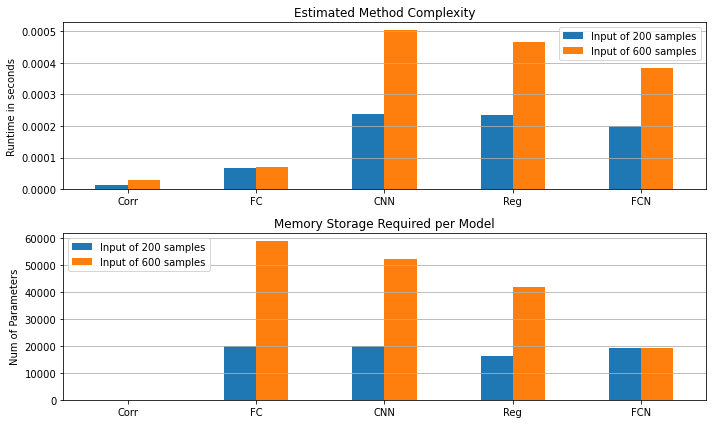

In [46]:
fig, ax = plt.subplots(2,1, figsize=(10,6))#, sharex="all")
df_times.plot(ax=ax[0], kind='bar', rot=0)
df_params.plot(ax=ax[1], kind='bar', rot=0)
# df_params.plot(ax=ax[1], kind='bar', rot=0 )
# ax.set_title('Time complexity')
# ax.right_ax.set_ylim(0,50000)
ax[0].set_title('Estimated Method Complexity')
ax[1].set_title('Memory Storage Required per Model')
for x in ax: x.get_legend().remove()
ax[0].legend(('Input of 200 samples', 'Input of 600 samples'))
ax[1].legend(('Input of 200 samples', 'Input of 600 samples'), loc='upper left')
ax[1].grid(axis='y')
ax[0].grid(axis='y')

ax[0].set_ylabel('Runtime in seconds')
ax[1].set_ylabel('Num of Parameters')
plt.tight_layout()

# plt.savefig('figures/complexity.png')

## Number of Params Scaling

In [47]:
lengths = np.arange(120, 800, 50)
macs_fc, macs_fcn, macs_ref, macs_osh = [], [], [], []
params_fc, params_fcn, params_ref, params_osh = [], [], [], []

for l in lengths:
    model = preamble_detector(l)
    params = sum([p.numel() for p in model.parameters()])
#     macs, params = get_model_complexity_info(model, (l*2,1), as_strings=False, print_per_layer_stat=False, verbose=False)
#     macs_fc.append(macs)
    params_fc.append(params)
    
for l in lengths:
    model = preamble_detector_fcn()
    params = sum([p.numel() for p in model.parameters()])
#     macs, params = get_model_complexity_info(model, (1,2,l), as_strings=False, print_per_layer_stat=False, verbose=False)
#     macs_fcn.append(macs)
    params_fcn.append(params)
    
for l in lengths:
    model = preamble_detector_ref(l)
    params = sum([p.numel() for p in model.parameters()])
#     macs, params = get_model_complexity_info(model, (1,2,l), as_strings=False, print_per_layer_stat=False, verbose=False)
#     macs_ref.append(macs)
    params_ref.append(params)
    
for l in lengths:
    model = preamble_detector_reg(l)
    params = sum([p.numel() for p in model.parameters()])
#     macs, params = get_model_complexity_info(model, (1,2,l), as_strings=False, print_per_layer_stat=False, verbose=False)
#     macs_osh.append(macs)
    params_osh.append(params)

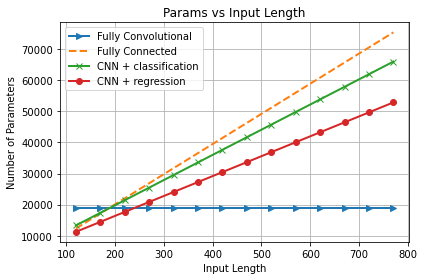

In [48]:
plt.plot(lengths, params_fcn, '->', linewidth=2)
plt.plot(lengths, params_fc, '--', linewidth=2)
plt.plot(lengths, params_ref, '-x', linewidth=2)
plt.plot(lengths, params_osh, '-o', linewidth=2)
plt.title('Params vs Input Length')
plt.grid()
plt.xlabel('Input Length')
plt.ylabel('Number of Parameters')
plt.legend(('Fully Convolutional', 'Fully Connected', 'CNN + classification', 'CNN + regression'))
plt.tight_layout()
# plt.savefig('figures/params_vs_input.png', dpi=300)

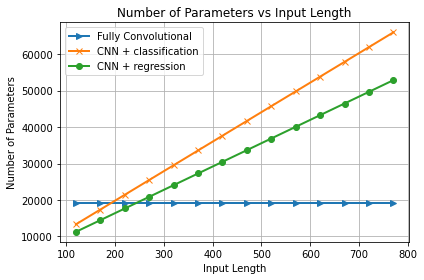

In [52]:
plt.plot(lengths, params_fcn, '->', linewidth=2)
# plt.plot(lengths, params_fc, '--', linewidth=2)
plt.plot(lengths, params_ref, '-x', linewidth=2)
plt.plot(lengths, params_osh, '-o', linewidth=2)
plt.title('Number of Parameters vs Input Length')
plt.grid()
plt.xlabel('Input Length')
plt.ylabel('Number of Parameters')
plt.legend(('Fully Convolutional', 'CNN + classification', 'CNN + regression'))
plt.tight_layout()
plt.savefig('figures/params_vs_input.png', dpi=300, bbox_inches='tight')

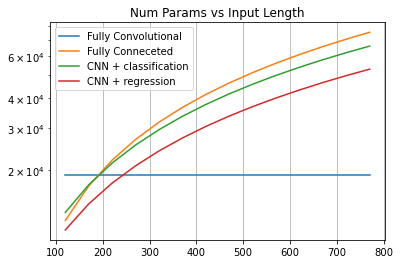

In [50]:
plt.semilogy(lengths, params_fcn)
plt.semilogy(lengths, params_fc)
plt.semilogy(lengths, params_ref)
plt.plot(lengths, params_osh)
plt.title('Num Params vs Input Length')
plt.grid()
plt.legend(('Fully Convolutional', 'Fully Conneceted', 'CNN + classification', 'CNN + regression'))